In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
import simulate

import models as models
from models import MLP, CNN, ResNet

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

with io.capture_output() as captured:
    pub_show()

GPU available


In [2]:
settings = pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)

In [3]:
def make_plots(setting, save=True):
    ## Load settings
    (
        model_type,
        nonlinearity,
        gain,
        lr,
        P,
        L,
        n_epochs,
        hidden_layer,
        dx2,
        dy2,
        in_dim,
        out_dim,
    ) = settings.loc[setting].to_numpy()
    model_type = getattr(models, model_type)
    if nonlinearity == "discontinuous":
        nonlinearity = simulate.Discontinuous.apply
    elif nonlinearity == "none":
        nonlinearity = None
    else:
        nonlinearity = getattr(torch.nn.functional, nonlinearity)

    ## Generate data
    input_dim, output_dim = in_dim, out_dim

    inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
        input_dim
    )
    outputs = np.array(
        [[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]
    ) / np.sqrt(output_dim)
    names = ["A", "B"]
    data = TensorDataset(
        torch.from_numpy(inputs.astype(np.float32)).to(device),
        torch.from_numpy(outputs.astype(np.float32)).to(device),
    )

    encoding = Encoding(dict(zip(names, inputs)))

    train_datasets = [data]
    val_dataset = [data]

    tracked_datasets = val_dataset + train_datasets

    ## Instantiate model
    model = model_type(
        encoding=encoding,
        input_size=inputs.shape[1],
        output_size=outputs.shape[1],
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
        non_linearity=nonlinearity,
    )

    ## Setup compiler

    # Define Loss, Optimizer
    criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
        "hidden": ActivationTracker(
            model, lambda inputs: model(inputs)[1][hidden_layer]
        ),
        "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
    }

    ## Training run
    compiler.training_run(
        train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
    )

    data_hid = compiler.trackers["hidden"].get_trace()
    data_output = compiler.trackers["output"].get_trace()
    loss = compiler.trackers["loss"].get_trace().copy()
    # val_loss = loss.query("Dataset==0")[0].to_numpy()
    train_loss = loss.groupby("Epoch").mean()
    train_loss = train_loss.to_numpy().ravel()

    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    y_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    y_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]

    epochs = np.arange(0, len(h_A))

    y_true_A, y_true_B = outputs[0], outputs[1]
    dy2 = np.sum((y_true_B - y_true_A) ** 2)
    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
    y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
    w = np.array(
        [
            y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
            for epoch in epochs
        ]
    )
    y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)

    h0, y0, w0, dy = h2[0], y2[0], w[0], dy2

    ## Comparison
    traj_path = "plots/2 points/trajectories/"

    eta_h_opt, eta_y_opt = simulate.optimize_eta(h2, y2, w, dx2, dy2)
    eta_h, eta_y = eta_h_opt, eta_y_opt

    t_max = len(epochs)

    sol = scipy.integrate.solve_ivp(
        simulate.der,
        [0, t_max],
        [h0, y0, w0],
        args=(eta_h, eta_y, dx2, dy2),
        dense_output=True,
    )

    t = np.linspace(0, t_max, len(epochs))
    z = sol.sol(t)
    t = epochs

    eta_y_mean_opt = simulate.optimize_eta_y_mean(z, train_loss, dy2, y0_mean)

    dh = h2[1:] - h2[:-1]
    loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)

    fig, ax = plt.subplots(figsize=(4, 3))
    plt.plot(t, z[0], linestyle="--")
    plt.plot(t, z[1], linestyle="--")
    plt.plot(t, z[2], linestyle="--")
    plt.gca().set_prop_cycle(None)
    ax.plot(t, h2, label="$||dh||^2$")
    ax.plot(t, y2, label="$||dy||^2$")
    ax.plot(t, w, label="$w$")
    if setting == "default":
        ax.legend()
    plt.xlabel("Epochs")
    if save:
        with io.capture_output() as captured:
            pub_show(save_path=traj_path + "ode/" + setting + ".png")

    ## STIL PROPORTIAL WITHOUT FITTING
    fig, ax = plt.subplots(figsize=(4, 3))
    plt.gca().set_prop_cycle(None)
    ax.plot(t[:-1], dh, label=r"$\frac{d}{dt}||dh||^2$")
    ax.plot(0, 0)
    ax.plot(t, -w, label="$-w$")
    if setting == "default":
        ax.legend()
    plt.ylim()
    plt.xlabel("Epochs")
    if save:
        with io.capture_output() as captured:
            pub_show(save_path=traj_path + "dh/" + setting + ".png")

    fig, ax = plt.subplots(figsize=(4, 3))
    plt.gca().set_prop_cycle(None)
    ax.plot(0, 0)
    ax.plot(0, 0)
    ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
    ax.plot(0, 0)
    ax.plot(t, train_loss, label="loss", zorder=1)
    if setting == "default":
        ax.legend()
    plt.ylim(0, 0.5)
    plt.xlabel("Epochs")
    if save:
        with io.capture_output() as captured:
            pub_show(save_path=traj_path + "loss/" + setting + ".png")

    return eta_h_opt, eta_y_opt

In [4]:
etas_h, etas_y = {}, {}
for setting in settings.index:
    print(f"\t\t\t\t\t-----{setting.upper()}-----")
    eta_h, eta_y = make_plots(setting, save=True)
    etas_h[setting] = eta_h
    etas_y[setting] = eta_y

					-----DEFAULT-----


Training:   0%|          | 12/3000 [00:00<00:54, 54.89steps/s, train_loss=0.34891, val_loss=0.34891]

Training: 100%|██████████| 3000/3000 [00:29<00:00, 100.21steps/s, train_loss=0.00000, val_loss=0.00000]


Loss: 2.1966746671160715
Loss: 0.07438655125775365


/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)


					-----GAIN_0.9-----


Training: 100%|██████████| 3000/3000 [00:24<00:00, 123.98steps/s, train_loss=0.00000, val_loss=0.00000]


Loss: 0.8565149893764297
Loss: 0.02898744683426123


/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)


					-----GAIN_1.1-----


Training: 100%|██████████| 3000/3000 [00:24<00:00, 124.36steps/s, train_loss=0.00000, val_loss=0.00000]


Loss: 0.054755855885083825
Loss: 0.010456410943454881


/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)


					-----GAIN_1.2-----


Training: 100%|██████████| 3000/3000 [00:30<00:00, 98.66steps/s, train_loss=0.00000, val_loss=0.00000] 


Loss: 0.33752217812636587
Loss: 0.014859562771764695


/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/rnn/DNN/simulate.py:100: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)


					-----GAIN_1.3-----


Training: 100%|██████████| 3000/3000 [00:26<00:00, 112.55steps/s, train_loss=0.00000, val_loss=0.00000]


Loss: 0.5171774720823922
Loss: 0.04438238393152458
					-----GAIN_1.4-----


Training: 100%|██████████| 3000/3000 [00:27<00:00, 107.95steps/s, train_loss=0.00000, val_loss=0.00000]


Loss: 1542.739439979103
Loss: 0.9648218514834548
					-----SHALLOW-----


Training:  61%|██████    | 1828/3000 [00:12<00:07, 149.25steps/s, train_loss=0.00020, val_loss=0.00020]


Loss: 1.0401806844811445


ValueError: unable to broadcast argument 4 to output array
File "/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/numba/np/npyimpl.py", line 227, 

Text(0, 0.5, '$\\frac{1}{\\tau_y}$')

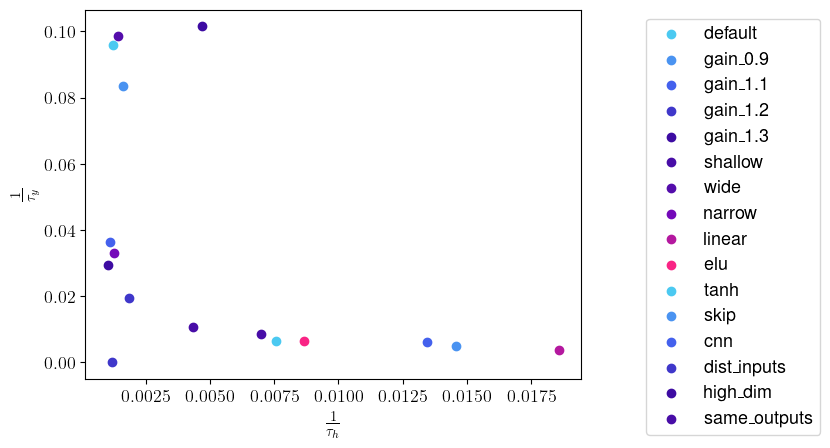

In [ ]:
for setting in settings.index:
    if setting in ["discontinuous", "early_layer", "late_layer", "gain_1.4","softplus"]:
        continue
    plt.scatter(etas_h[setting], etas_y[setting], label=f"{setting}")
plt.legend(bbox_to_anchor=(1.5, 1))
# plt.xlim(0)
# plt.ylim(0)
plt.xlabel(r"$\frac{1}{\tau_h}$")
plt.ylabel(r"$\frac{1}{\tau_y}$")